In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns

c:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part A: Data Setup

In [8]:
# data preprocessing

# df = pd.read_csv("data/COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")
df = pd.read_csv("out.csv")

# designate which columns I want to use
cols = ['chi', 'lin_reg', 'lin_reg_chi', 'stddev_step_speed', 'label']

df = df[cols]

# remove all entries with Missing or NaN
for i in cols:
   df = df[df[i] != 'Missing']
   df = df[df[i] != 'NaN']
   df = df[df[i] != 'Unknown']

print(df)


                chi   lin_reg  lin_reg_chi  stddev_step_speed  label
0      8.474767e+04  0.992533     0.988869          17.360221      0
1      2.097220e+04  0.973844     1.938908          17.308306      0
2      2.356781e+04  0.894242     6.604954          17.300169      0
3      8.100880e+03  0.967026     5.758685          17.376369      0
4      5.593839e+05  0.000296     1.512429          17.205146      0
...             ...       ...          ...                ...    ...
16075  4.669320e+05  0.999245     0.867075          18.036484      0
16076  1.375967e+06  0.999707     1.345129          26.151765      0
16077  2.235552e+06  0.998892     3.587700          23.801682      0
16078  6.701228e+05  0.998953     0.680709          16.319528      0
16079  6.096492e+05  0.999056     7.286809          30.031311      0

[16080 rows x 5 columns]


In [13]:
# TODO: make sure your data can be converted to torch tensors

df_train = df[['chi', 'lin_reg', 'lin_reg_chi', 'stddev_step_speed']].copy()
df_test = df['label'].copy()

print(df_train)

train_X = torch.tensor((df_train.iloc[0:14000]).to_numpy(), dtype = torch.float32)
train_y = torch.tensor((df_test.iloc[0:14000]).to_numpy(), dtype = torch.float32)

test_X = torch.tensor((df_train.iloc[14000:16079]).to_numpy(), dtype = torch.float32)
test_y = torch.tensor((df_test.iloc[14000:16079]).to_numpy(), dtype = torch.float32)


# make datasets and dataloaders

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40, shuffle=True) 


                chi   lin_reg  lin_reg_chi  stddev_step_speed
0      8.474767e+04  0.992533     0.988869          17.360221
1      2.097220e+04  0.973844     1.938908          17.308306
2      2.356781e+04  0.894242     6.604954          17.300169
3      8.100880e+03  0.967026     5.758685          17.376369
4      5.593839e+05  0.000296     1.512429          17.205146
...             ...       ...          ...                ...
16075  4.669320e+05  0.999245     0.867075          18.036484
16076  1.375967e+06  0.999707     1.345129          26.151765
16077  2.235552e+06  0.998892     3.587700          23.801682
16078  6.701228e+05  0.998953     0.680709          16.319528
16079  6.096492e+05  0.999056     7.286809          30.031311

[16080 rows x 4 columns]


# Part B: Linear Neural Network

## Model Setup

In [27]:
model = nn.Sequential(
    nn.BatchNorm1d(4),
    nn.Flatten(),
    nn.Linear(4, 1),
    #nn.Dropout(0.07),
    nn.Sigmoid()
)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = nn.BCELoss()

#torch.manual_seed(15552494823729223621)
#15552494823729223621 97.9
#6202543811676496745 98.01

#4012035888747445639 98.17

Sequential(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


## Training Loop

In [28]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        target = target.unsqueeze(1)
        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

RuntimeError: all elements of input should be between 0 and 1

## Testing Loop

In [ ]:
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        target = target.unsqueeze(1)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: nan, Accuracy: 1035/2079 (49.7835)


## Weight Matrix Visualization

c:\Python39\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Python39\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot:>

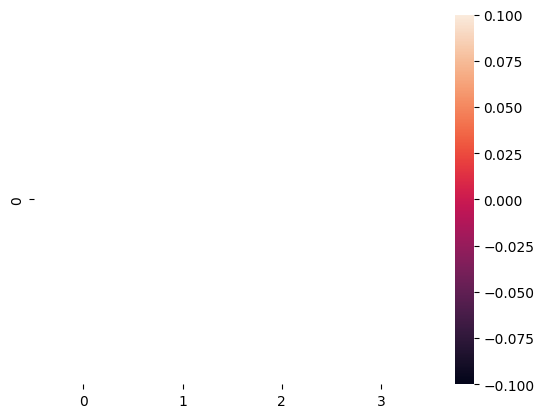

In [ ]:
weights = model.state_dict()['1.weight']

sns.heatmap(weights)

# Part C: 2-Layer Linear Model

In [ ]:
model = nn.Sequential(

    nn.Flatten(),
    nn.Linear(5, 3),
    nn.Linear(3, 1),
    #nn.Dropout(0.07),
    nn.Softmax(dim=1)
)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = nn.BCELoss()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=5, out_features=3, bias=True)
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): Softmax(dim=1)
)
